<font size="6.5">**Joint Distribution Fitting for Two Resources**

<font size="3">This file takes raw transaction data as an input. We model the two resources, gas and calldata length, jointly by identifying and separately modeling clusters of the data. The output is a list of generated transactions jointly distributed with resources gas and calldata length. The goal of this file is to find various clusters in the raw dataset and model them with multiple joint distributions. Then, we can simulate transactions based on the estimated parameters of the cluster distributions.

    
<font size="3">The input file TxF22.csv is generated with simulator.py

In [7]:
#Import necessary packages and raw data file

import sys; sys.path.insert(0, '..')  # this adds the parent directory into the path, since we want simulations from the parent directory
from settings import DATA_PATH

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
from sklearn.utils import shuffle
import random
from sklearn.linear_model import LinearRegression
import seaborn as sns
from collections import Counter 
from math import e
from random import randint
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from numpy import inf

file='transactionDataContinuous_Clean.csv' 
data=pd.read_csv(str(DATA_PATH / file)) 


<font size="5">**Data Partitioning and Cleaning**
    
<font size="3">We split the data into training and test sets so that we can fit the distributions on the training data and evaluate fitment on the test data. 

In [146]:
TxGas=list(data['gas']) #gas used per Tx
TxCallData=list(data['input']) 
TxCallData=[len(x[2:]) for x in TxCallData] #length of calldata after '0x' string for each entry

#Now randomly sample x and 1-x % of Tx to create test and training sets
np.random.seed(10)
(TxGas,TxCallData) = shuffle(TxGas,TxCallData) 
df=pd.DataFrame({'TxGas':TxGas,'TxCallData':TxCallData})
testSize=20 # % of Txs that will make up test set
TxGasTest=TxGas[0:round(len(TxGas)*testSize/100)]
TxGasTrain=TxGas[round(len(TxGas)*testSize/100):]

TxCallDataTest=TxCallData[0:round(len(TxCallData)*testSize/100)]
TxCallDataTrain=TxCallData[round(len(TxCallData)*testSize/100):]
dfTrain=pd.DataFrame({'TxGas':TxGasTrain,'TxCallData':TxCallDataTrain})
dfTest=pd.DataFrame({'TxGas':TxGasTest,'TxCallData':TxCallDataTest})



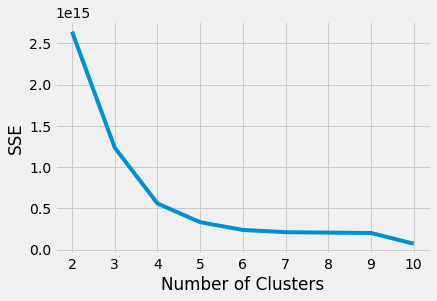

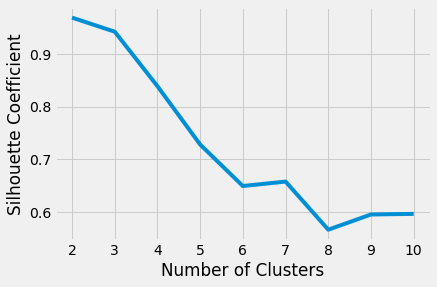

In [147]:

kmeans_kwargs = {"init": "random"}
sse=[]
silhouette_coefficients=[]
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df)
    sse.append(kmeans.inertia_)
    score = silhouette_score(df, kmeans.labels_)
    silhouette_coefficients.append(score)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), sse)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()


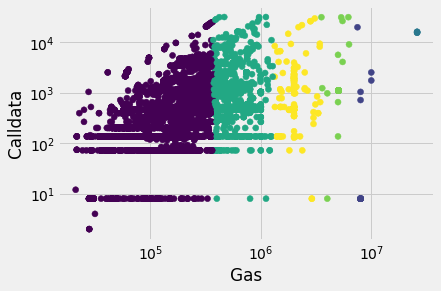

In [148]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(df)

plt.scatter(df.iloc[:,0], df.iloc[:,1], c=kmeans.labels_)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Gas")
plt.ylabel("Calldata")
plt.show()

Now try to fit to the log of the data in order to better separate the horizontal lines

In [149]:
logTxGasTrain=[np.log(TxGasTrain[i]) if TxGasTrain[i]!=0 else TxGasTrain[i] for i in range(len(TxGasTrain))]
logTxCallDataTrain=[np.log(TxCallDataTrain[i]) if TxCallDataTrain[i]!=0 else TxCallDataTrain[i] for i in range(len(TxCallDataTrain))]

logDfTrain=pd.DataFrame({'TxGas':logTxGasTrain,'TxCallData':logTxCallDataTrain})


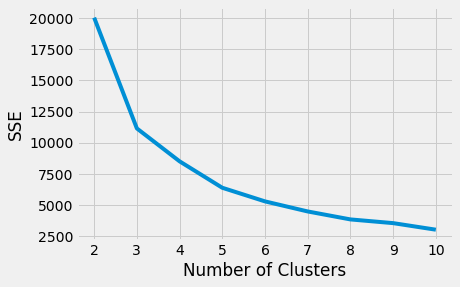

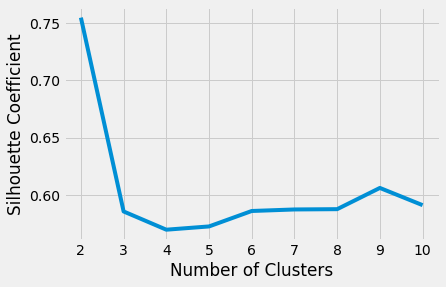

In [150]:

kmeans_kwargs = {"init": "random"}
sse=[]
silhouette_coefficients=[]
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(logDfTrain)
    sse.append(kmeans.inertia_)
    score = silhouette_score(logDfTrain, kmeans.labels_)
    silhouette_coefficients.append(score)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), sse)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()


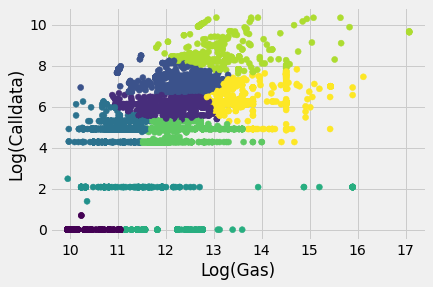

In [151]:
kmeans = KMeans(n_clusters=9)
kmeans.fit(logDfTrain)
cluster_map = pd.DataFrame() #create frame that can be used to organize data by cluster
cluster_map['data_index'] = logDfTrain.index.values
cluster_map['cluster'] = kmeans.labels_

plt.scatter(logDfTrain.iloc[:,0], logDfTrain.iloc[:,1], c=kmeans.labels_)
plt.xlabel("Log(Gas)")
plt.ylabel("Log(Calldata)")
plt.show()

/var/folders/6v/wkrmh2153t33rw_7s71g3c3m0000gn/T/ipykernel_4712/1077542027.py:18: RuntimeWarning: divide by zero encountered in log
  logCallData=np.log(clusteredCD[i])
/var/folders/6v/wkrmh2153t33rw_7s71g3c3m0000gn/T/ipykernel_4712/1077542027.py:18: RuntimeWarning: divide by zero encountered in log
  logCallData=np.log(clusteredCD[i])


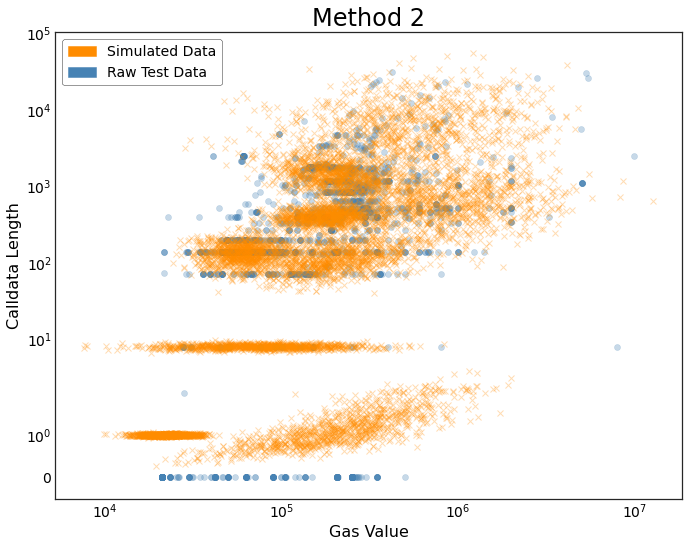

In [230]:
lenGenerated=1000
clusteredGas=[list(dfTrain['TxGas'][cluster_map['cluster']==i])  for i in range(len(np.unique(cluster_map.cluster)))]
clusteredCD=[list(dfTrain['TxCallData'][cluster_map['cluster']==i])  for i in range(len(np.unique(cluster_map.cluster)))]


fig,ax=plt.subplots(figsize=(10,8),facecolor='white')
ax.patch.set_facecolor('white')
ax.grid(False)
ax.scatter(TxGasTest,TxCallDataTest,color='steelblue',label='Raw Test Data',alpha=0.3)
plt.title('Raw and Generated Data', fontsize=18)
plt.xlabel('Gas Value', fontsize=16)
ax.set_xscale('symlog')
ax.set_yscale('symlog')
plt.ylabel('Calldata Length', fontsize=16)

for i in range(len(np.unique(cluster_map['cluster']))):
    logGas=np.log(clusteredGas[i])
    logCallData=np.log(clusteredCD[i])
    logCallData[logCallData==-inf]=0#take log unless 0
    logCovMat=np.cov(logGas,logCallData)
    logMuGas=np.mean(logGas)
    logMuCallData=np.mean(logCallData)
    x, y = np.random.multivariate_normal([logMuGas,logMuCallData], logCovMat, round(lenGenerated*len(cluster_map['cluster']==i)/len(cluster_map)) ).T
    plt.plot(np.exp(x), np.exp(y), 'x',color='darkorange',alpha=0.3)#,label='Simulated Data')

import matplotlib.patches as mpatches
a = mpatches.Patch(color='darkorange', label='Simulated Data')#,marker='o')
b = mpatches.Patch(color='steelblue', label='Raw Test Data')#,marker='x')
plt.legend(handles=[a,b],facecolor='white',edgecolor='k')

plt.show()


In [153]:

minSamples=list(range(20))
eRange=np.linspace(.1,2,20)

silhouette_coefficients = [[0]*len(minSamples)]*len(eRange)

for n in range(len(minSamples)):
    for e in range(len(eRange)):
        db = DBSCAN(eps=eRange[e], min_samples=minSamples[n])
        db.fit(logDfTrain)
        score = silhouette_score(logDfTrain, db.labels_)
        silhouette_coefficients[n][e]=score
        

        n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
        n_noise_ = list(db.labels_).count(-1)
        #print("Estimated number of clusters: %d" % n_clusters_)




ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [ ]:
f, ax = plt.subplots(figsize=(11, 15)) 
heatmap = sns.heatmap(silhouette_coefficients, 
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4, 
                      'ticks' : [ 0, 0.5, 1]},
                      vmin = 0, 
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 10})
#add the column names as labels
ax.set_yticklabels([round(minSamples[i],1)  for i in range(len(minSamples))], rotation = 0)
ax.set_xticklabels([round(eRange[i],1)  for i in range(len(eRange))],rotation = 45)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})


In [ ]:
#alternatively do this to select e and n
#find best e by taking the crook of the elbow
#best minSamples=2*dims
# https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(logDfTrain)
distances, indices = neighbors_fit.kneighbors(logDfTrain)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances);

In [ ]:
from kneed import KneeLocator
kn = KneeLocator(list(range(len(distances))), distances, curve='convex', direction='increasing')
elbow=(distances[kn.knee])



In [ ]:
dims=np.shape(logDfTrain)[1]
db = DBSCAN(eps=elbow, min_samples=2*dims)
db.fit(logDfTrain)
score = silhouette_score(logDfTrain, db.labels_)
silhouette_coefficients[n][e]=score


n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
n_noise_ = list(db.labels_).count(-1)
print("Estimated number of clusters: %d" % n_clusters_)
plt.scatter(logDfTrain.iloc[:,0], logDfTrain.iloc[:,1], c=db.labels_)
plt.show()

In [195]:
np.asarray(clusteredCD[i])>0

array([False, False, False, ..., False, False, False])

In [197]:
type(np.array(clusteredCD[6])>0)

numpy.ndarray

/var/folders/6v/wkrmh2153t33rw_7s71g3c3m0000gn/T/ipykernel_4712/1033049022.py:2: RuntimeWarning: divide by zero encountered in log
  a=np.log(clusteredCD[0])


array([0., 0., 0., ..., 0., 0., 0.])

In [191]:
type(np.linspace(0,5,5))

numpy.ndarray